# Inference pipeline

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [3]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_post_00171.png'),
 PosixPath('data/test/images/test_pre_00064.png')]

In [4]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [5]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [6]:
len(preimgs), len(posimgs)

(933, 933)

In [7]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_pre_00064.png'),
 PosixPath('data/test/images/test_pre_00091.png')]

In [8]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00831.png'),
 PosixPath('data/test/images/test_post_00064.png'),
 PosixPath('data/test/images/test_post_00091.png')]

### Building detection

In [9]:
#seglearn = load_learner('./', file='building_detector.pkl', test=SegItemListCustom(preimgs), tfm_y=False)
seglearn = load_learner('./', file='sz1024_bs2_resnet34_8epochcycle_stage5.pkl')

In [10]:
#y_mask, pred_mask, raw_pred_mask = seglearn.get_preds(ds_type=DatasetType.Test)

In [11]:
idx = 117

#idx = 67 #all undamaged  
#idx = 34 #no features

In [12]:
img = open_image(preimgs[idx])
print(preimgs[idx])

data/test/images/test_pre_00290.png


In [13]:
%%time
y_mask, pred_mask, raw_pred_mask = seglearn.predict(img)

CPU times: user 940 ms, sys: 144 ms, total: 1.08 s
Wall time: 1.01 s


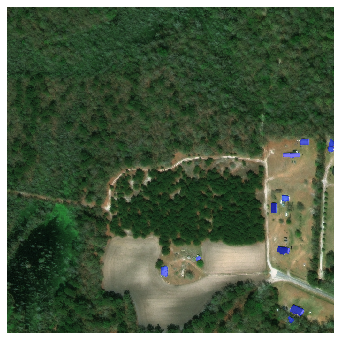

In [14]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
y_mask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Building mask -> polygons

In [15]:
_, polys = bmask2polys(y_mask.data[0].numpy())

In [16]:
type(polys), len(polys)

(numpy.ndarray, 12)

### Generate unique ids for polygons

In [17]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [18]:
uids = generate_uid_polys(polys)

### Get polygon images

In [19]:
path = Path('tmp_polyimgs')

In [20]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)

In [21]:
img = open_image(posimgs[idx])

In [22]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(path/f'{uid}.png')

Refactor into function.

In [23]:
#export
def polyimgs2disk(img, polys, path=None):
    if path is None: path = Path('tmp_polyimgs')
    shutil.rmtree(path, ignore_errors=True); os.makedirs(path, exist_ok=True)
    if len(polys) == 0: return path, []
    uids = generate_uid_polys(polys)
    for uid, p in zip(uids, polys): crop_by_polygon(img, p).save(path/f'{uid}.png')
    return path, uids

In [24]:
path, uids = polyimgs2disk(img, polys, path)

In [25]:
len(path.ls()), len(uids)

(12, 12)

### Damage classification

In [26]:
%%time
il = ImageList([path/f'{uid}.png' for uid in uids])
damglearn = load_learner('./', file='best_model_damg_nsample42000_sz299_bs32_resnet152.pkl', test=il)

CPU times: user 292 ms, sys: 156 ms, total: 448 ms
Wall time: 337 ms


In [27]:
len(il.items)

12

In [28]:
%%time
pred_damg, y_damg = damglearn.get_preds(ds_type=DatasetType.Test)

CPU times: user 124 ms, sys: 208 ms, total: 332 ms
Wall time: 523 ms


In [29]:
pred_classes = [damglearn.data.classes[i] for i in pred_damg.argmax(dim=1)]

In [30]:
pred_classes[3], pred_damg[3], y_damg[3], y_damg.sum()

('major', tensor([-3.4438,  1.8134,  5.3363, -0.1258]), tensor(0), tensor(0))

In [31]:
len(pred_classes), len(uids), len(polys), img

(12, 12, 12, Image (3, 1024, 1024))

Refactor into function.

In [32]:
#export
def assess_damage_polyimgs(polyimgs, path='./', file='damg_sz299_bs32_resnet50_mixup_stage2.pkl'):
    if len(polyimgs.items) == 0: return [] # Need `.items` because `len(ImageList)` is 1 for empty list.
    damglearn = load_learner(path, file, test=polyimgs)
    pred_damg, _ = damglearn.get_preds(ds_type=DatasetType.Test)
    return [damglearn.data.classes[o] for o in pred_damg.argmax(dim=1)]

In [33]:
polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
damgs = assess_damage_polyimgs(polyimgs)

In [34]:
damgs[3], len(damgs)

('major', 12)

### Damage mask

In [35]:
CATS

['nun', 'minor', 'major', 'destroyed']

In [36]:
#export
DAMG_OTOI = {'nun':1, 'minor':2, 'major':3, 'destroyed':4}

In [37]:
damgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [38]:
for damg, poly in zip(damgs, polys):
    cv2.fillPoly(damgmask, poly[None,...], (DAMG_OTOI[damg]))
    
damgmask = ImageSegment(tensor(damgmask[None,...]))

Refactor into function.

In [39]:
#export
def damgpolys2damgmask(polys, damgs, sz=1024):
    assert len(polys) == len(damgs)
    if isinstance(sz, int): sz = (sz, sz)
    mask = np.zeros(sz, dtype=np.uint8)
    if len(polys) > 0:
        for damg, poly in zip(damgs, polys): 
            cv2.fillPoly(mask, poly[None,...], (DAMG_OTOI[damg]))
    return ImageSegment(tensor(mask[None,...]))

In [40]:
damgmask = damgpolys2damgmask(polys, damgs, img.shape[1:])

In [41]:
damgmask.data.unique()

tensor([0, 3])

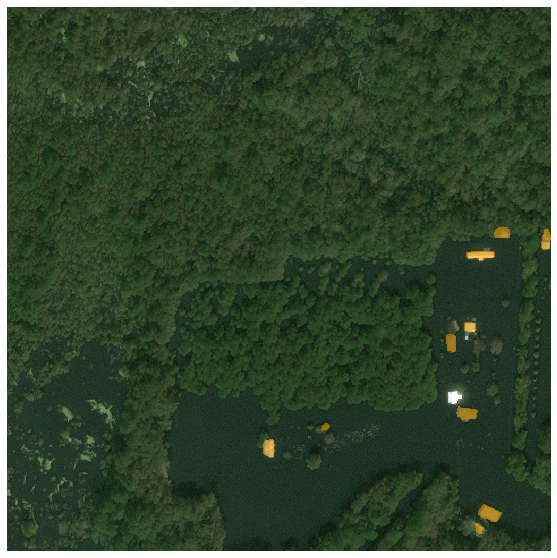

In [42]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
damgmask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Pipeline

In [43]:
#export
def infer_sample(path_preimg, path_posimg, seglearn, path_damglearn):
    img = open_image(path_preimg)
    y_mask, _, _ = seglearn.predict(img)
    _, polys = bmask2polys(y_mask.data[0].numpy())
    img = open_image(path_posimg)
    path, uids = polyimgs2disk(img, polys, path=Path('tmp_polyimgs'))
    polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
    damgs = assess_damage_polyimgs(polyimgs, file=path_damglearn)
    damgmask = damgpolys2damgmask(polys, damgs, sz=img.shape[1:])
    return damgmask

def get_imgid(imgname): return imgname.stem.split('_')[-1]

In [44]:
path_results = Path('./inference_results_dcedf650b7')

In [45]:
os.makedirs(path_results, exist_ok=True)

In [46]:
idx = 332
damgmask = infer_sample(preimgs[idx], posimgs[idx], seglearn, 'best_model_damg_nsample42000_sz299_bs32_resnet152.pkl')

tensor([0, 1, 2, 3, 4])

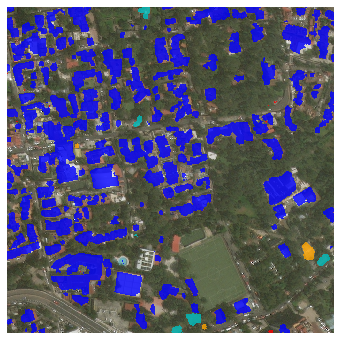

In [47]:
_, ax = plt.subplots(figsize=(6, 6))
open_image(posimgs[idx]).show(ax)
damgmask.show(ax, alpha=.8, cmap=CMAP, vmax=len(CMAP.colors)-1)
damgmask.data.unique()

Takes about 40 minutes to generate the inference .pngs for the entire test set.

In [49]:
for idx in progress_bar(range(len(preimgs))):
    npre, npos = preimgs[idx], posimgs[idx]
    damgmask = infer_sample(npre, npos, seglearn, 'best_model_damg_nsample42000_sz299_bs32_resnet152.pkl')
    imgid = get_imgid(npre)
    damgmask.save(path_results/f'test_localization_{imgid}_prediction.png')
    damgmask.save(path_results/f'test_damage_{imgid}_prediction.png')

### Load a few saved submission png files

In [50]:
print(len(get_image_files(path_results)))
get_image_files(path_results)[:5]

1866


[PosixPath('inference_results_dcedf650b7/test_localization_00536_prediction.png'),
 PosixPath('inference_results_dcedf650b7/test_damage_00313_prediction.png'),
 PosixPath('inference_results_dcedf650b7/test_damage_00142_prediction.png'),
 PosixPath('inference_results_dcedf650b7/test_localization_00376_prediction.png'),
 PosixPath('inference_results_dcedf650b7/test_damage_00919_prediction.png')]

In [56]:
#imgid = get_imgid(preimgs[117])
imgid = get_imgid(preimgs[332]) #Lots of buildings [0, 1, 3, 4]
# imgid = '00064'  no buildings

In [57]:
path_local = path_results/f'test_localization_{imgid}_prediction.png'
path_damg = path_results/f'test_damage_{imgid}_prediction.png'

In [58]:
np.unique(PIL.Image.open(path_damg))

array([0, 1, 2, 3, 4], dtype=uint8)

In [59]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

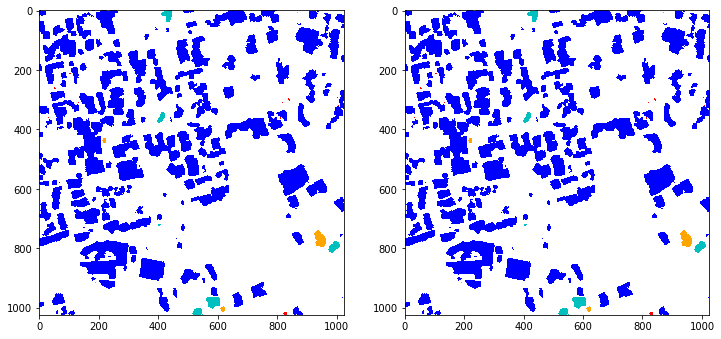

In [60]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 15))
axs[0].imshow(np.array(PIL.Image.open(path_local)), cmap=CMAP, vmin=0, vmax=4)
axs[1].imshow(np.array(PIL.Image.open(path_damg)), cmap=CMAP, vmin=0, vmax=4);

In [61]:
mask_local, mask_damg = open_mask(path_local), open_mask(path_damg)

In [62]:
mask_local.data.unique(), mask_damg.data.unique()

(tensor([0, 1, 2, 3, 4]), tensor([0, 1, 2, 3, 4]))

In [63]:
CMAP.colors

['None', 'b', 'c', 'orange', 'r']

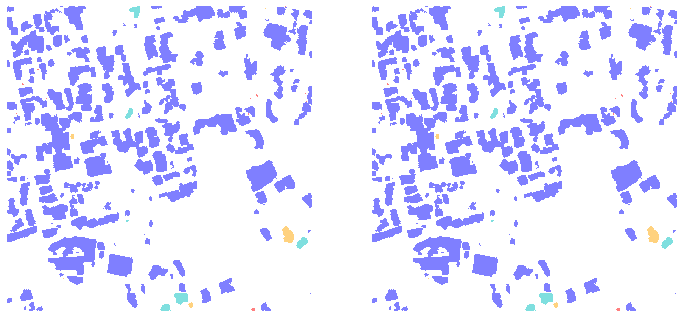

In [64]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))
open_mask(path_local).show(axs[0], cmap=CMAP, vmax=len(CMAP.colors) - 1)
open_mask(path_damg).show(axs[1], cmap=CMAP, vmax=len(CMAP.colors) - 1)

### Save submission png files into tarball

In [65]:
#! tar czvf inference_results_dcedf650b7.tar.gz {path_results}

inference_results_dcedf650b7/
inference_results_dcedf650b7/test_localization_00536_prediction.png
inference_results_dcedf650b7/test_damage_00313_prediction.png
inference_results_dcedf650b7/test_damage_00142_prediction.png
inference_results_dcedf650b7/test_localization_00376_prediction.png
inference_results_dcedf650b7/test_damage_00919_prediction.png
inference_results_dcedf650b7/test_localization_00111_prediction.png
inference_results_dcedf650b7/test_localization_00065_prediction.png
inference_results_dcedf650b7/test_damage_00620_prediction.png
inference_results_dcedf650b7/test_localization_00315_prediction.png
inference_results_dcedf650b7/test_localization_00206_prediction.png
inference_results_dcedf650b7/test_localization_00556_prediction.png
inference_results_dcedf650b7/test_localization_00789_prediction.png
inference_results_dcedf650b7/test_localization_00435_prediction.png
inference_results_dcedf650b7/test_localization_00931_prediction.png
inference_results_dcedf650b7/test_damage_0

inference_results_dcedf650b7/test_localization_00825_prediction.png
inference_results_dcedf650b7/test_localization_00712_prediction.png
inference_results_dcedf650b7/test_damage_00893_prediction.png
inference_results_dcedf650b7/test_damage_00505_prediction.png
inference_results_dcedf650b7/test_damage_00503_prediction.png
inference_results_dcedf650b7/test_damage_00682_prediction.png
inference_results_dcedf650b7/test_localization_00392_prediction.png
inference_results_dcedf650b7/test_damage_00897_prediction.png
inference_results_dcedf650b7/test_localization_00268_prediction.png
inference_results_dcedf650b7/test_damage_00241_prediction.png
inference_results_dcedf650b7/test_damage_00696_prediction.png
inference_results_dcedf650b7/test_localization_00132_prediction.png
inference_results_dcedf650b7/test_localization_00094_prediction.png
inference_results_dcedf650b7/test_localization_00328_prediction.png
inference_results_dcedf650b7/test_localization_00351_prediction.png
inference_results_dced

inference_results_dcedf650b7/test_localization_00108_prediction.png
inference_results_dcedf650b7/test_localization_00706_prediction.png
inference_results_dcedf650b7/test_localization_00879_prediction.png
inference_results_dcedf650b7/test_damage_00836_prediction.png
inference_results_dcedf650b7/test_damage_00594_prediction.png
inference_results_dcedf650b7/test_localization_00114_prediction.png
inference_results_dcedf650b7/test_localization_00413_prediction.png
inference_results_dcedf650b7/test_damage_00106_prediction.png
inference_results_dcedf650b7/test_localization_00603_prediction.png
inference_results_dcedf650b7/test_localization_00140_prediction.png
inference_results_dcedf650b7/test_localization_00525_prediction.png
inference_results_dcedf650b7/test_damage_00177_prediction.png
inference_results_dcedf650b7/test_localization_00759_prediction.png
inference_results_dcedf650b7/test_localization_00608_prediction.png
inference_results_dcedf650b7/test_damage_00009_prediction.png
inference_

inference_results_dcedf650b7/test_localization_00275_prediction.png
inference_results_dcedf650b7/test_damage_00589_prediction.png
inference_results_dcedf650b7/test_localization_00767_prediction.png
inference_results_dcedf650b7/test_damage_00771_prediction.png
inference_results_dcedf650b7/test_localization_00417_prediction.png
inference_results_dcedf650b7/test_damage_00756_prediction.png
inference_results_dcedf650b7/test_localization_00817_prediction.png
inference_results_dcedf650b7/test_damage_00027_prediction.png
inference_results_dcedf650b7/test_localization_00339_prediction.png
inference_results_dcedf650b7/test_damage_00393_prediction.png
inference_results_dcedf650b7/test_damage_00441_prediction.png
inference_results_dcedf650b7/test_damage_00722_prediction.png
inference_results_dcedf650b7/test_damage_00052_prediction.png
inference_results_dcedf650b7/test_localization_00928_prediction.png
inference_results_dcedf650b7/test_damage_00600_prediction.png
inference_results_dcedf650b7/test_

inference_results_dcedf650b7/test_damage_00299_prediction.png
inference_results_dcedf650b7/test_localization_00638_prediction.png
inference_results_dcedf650b7/test_damage_00522_prediction.png
inference_results_dcedf650b7/test_damage_00145_prediction.png
inference_results_dcedf650b7/test_localization_00079_prediction.png
inference_results_dcedf650b7/test_localization_00607_prediction.png
inference_results_dcedf650b7/test_localization_00790_prediction.png
inference_results_dcedf650b7/test_localization_00153_prediction.png
inference_results_dcedf650b7/test_localization_00575_prediction.png
inference_results_dcedf650b7/test_damage_00626_prediction.png
inference_results_dcedf650b7/test_localization_00155_prediction.png
inference_results_dcedf650b7/test_damage_00628_prediction.png
inference_results_dcedf650b7/test_localization_00718_prediction.png
inference_results_dcedf650b7/test_damage_00662_prediction.png
inference_results_dcedf650b7/test_localization_00310_prediction.png
inference_result

inference_results_dcedf650b7/test_damage_00637_prediction.png
inference_results_dcedf650b7/test_localization_00610_prediction.png
inference_results_dcedf650b7/test_damage_00402_prediction.png
inference_results_dcedf650b7/test_damage_00932_prediction.png
inference_results_dcedf650b7/test_localization_00482_prediction.png
inference_results_dcedf650b7/test_damage_00406_prediction.png
inference_results_dcedf650b7/test_localization_00701_prediction.png
inference_results_dcedf650b7/test_damage_00233_prediction.png
inference_results_dcedf650b7/test_localization_00505_prediction.png
inference_results_dcedf650b7/test_localization_00470_prediction.png
inference_results_dcedf650b7/test_localization_00545_prediction.png
inference_results_dcedf650b7/test_damage_00478_prediction.png
inference_results_dcedf650b7/test_localization_00532_prediction.png
inference_results_dcedf650b7/test_damage_00904_prediction.png
inference_results_dcedf650b7/test_damage_00432_prediction.png
inference_results_dcedf650b7

inference_results_dcedf650b7/test_damage_00815_prediction.png
inference_results_dcedf650b7/test_damage_00916_prediction.png
inference_results_dcedf650b7/test_damage_00201_prediction.png
inference_results_dcedf650b7/test_damage_00839_prediction.png
inference_results_dcedf650b7/test_damage_00071_prediction.png
inference_results_dcedf650b7/test_damage_00403_prediction.png
inference_results_dcedf650b7/test_damage_00310_prediction.png
inference_results_dcedf650b7/test_localization_00199_prediction.png
inference_results_dcedf650b7/test_localization_00119_prediction.png
inference_results_dcedf650b7/test_damage_00296_prediction.png
inference_results_dcedf650b7/test_damage_00728_prediction.png
inference_results_dcedf650b7/test_localization_00831_prediction.png
inference_results_dcedf650b7/test_localization_00190_prediction.png
inference_results_dcedf650b7/test_damage_00330_prediction.png
inference_results_dcedf650b7/test_damage_00428_prediction.png
inference_results_dcedf650b7/test_localization

inference_results_dcedf650b7/test_damage_00013_prediction.png
inference_results_dcedf650b7/test_damage_00171_prediction.png
inference_results_dcedf650b7/test_damage_00845_prediction.png
inference_results_dcedf650b7/test_damage_00895_prediction.png
inference_results_dcedf650b7/test_localization_00414_prediction.png
inference_results_dcedf650b7/test_localization_00080_prediction.png
inference_results_dcedf650b7/test_damage_00126_prediction.png
inference_results_dcedf650b7/test_damage_00088_prediction.png
inference_results_dcedf650b7/test_damage_00319_prediction.png
inference_results_dcedf650b7/test_damage_00802_prediction.png
inference_results_dcedf650b7/test_localization_00661_prediction.png
inference_results_dcedf650b7/test_damage_00663_prediction.png
inference_results_dcedf650b7/test_damage_00578_prediction.png
inference_results_dcedf650b7/test_localization_00613_prediction.png
inference_results_dcedf650b7/test_damage_00282_prediction.png
inference_results_dcedf650b7/test_damage_00471

inference_results_dcedf650b7/test_damage_00915_prediction.png
inference_results_dcedf650b7/test_damage_00339_prediction.png
inference_results_dcedf650b7/test_localization_00460_prediction.png
inference_results_dcedf650b7/test_damage_00135_prediction.png
inference_results_dcedf650b7/test_damage_00508_prediction.png
inference_results_dcedf650b7/test_damage_00553_prediction.png
inference_results_dcedf650b7/test_localization_00700_prediction.png
inference_results_dcedf650b7/test_damage_00361_prediction.png
inference_results_dcedf650b7/test_localization_00412_prediction.png
inference_results_dcedf650b7/test_localization_00138_prediction.png
inference_results_dcedf650b7/test_localization_00633_prediction.png
inference_results_dcedf650b7/test_localization_00259_prediction.png
inference_results_dcedf650b7/test_localization_00421_prediction.png
inference_results_dcedf650b7/test_localization_00373_prediction.png
inference_results_dcedf650b7/test_damage_00427_prediction.png
inference_results_dced

inference_results_dcedf650b7/test_damage_00742_prediction.png
inference_results_dcedf650b7/test_damage_00567_prediction.png
inference_results_dcedf650b7/test_localization_00744_prediction.png
inference_results_dcedf650b7/test_damage_00632_prediction.png
inference_results_dcedf650b7/test_damage_00501_prediction.png
inference_results_dcedf650b7/test_localization_00416_prediction.png
inference_results_dcedf650b7/test_damage_00684_prediction.png
inference_results_dcedf650b7/test_damage_00187_prediction.png
inference_results_dcedf650b7/test_localization_00829_prediction.png
inference_results_dcedf650b7/test_damage_00752_prediction.png
inference_results_dcedf650b7/test_localization_00674_prediction.png
inference_results_dcedf650b7/test_localization_00367_prediction.png
inference_results_dcedf650b7/test_localization_00600_prediction.png
inference_results_dcedf650b7/test_damage_00215_prediction.png
inference_results_dcedf650b7/test_damage_00770_prediction.png
inference_results_dcedf650b7/test_

inference_results_dcedf650b7/test_damage_00624_prediction.png
inference_results_dcedf650b7/test_localization_00550_prediction.png
inference_results_dcedf650b7/test_damage_00843_prediction.png
inference_results_dcedf650b7/test_localization_00547_prediction.png
inference_results_dcedf650b7/test_localization_00463_prediction.png
inference_results_dcedf650b7/test_damage_00863_prediction.png
inference_results_dcedf650b7/test_damage_00557_prediction.png
inference_results_dcedf650b7/test_damage_00532_prediction.png
inference_results_dcedf650b7/test_damage_00790_prediction.png
inference_results_dcedf650b7/test_localization_00354_prediction.png
inference_results_dcedf650b7/test_damage_00229_prediction.png
inference_results_dcedf650b7/test_damage_00799_prediction.png
inference_results_dcedf650b7/test_localization_00335_prediction.png
inference_results_dcedf650b7/test_localization_00442_prediction.png
inference_results_dcedf650b7/test_localization_00687_prediction.png
inference_results_dcedf650b7

In [66]:
! du -hs inference_results*

18M	inference_results
12M	inference_results.tar.gz
17M	inference_results_dcedf650b7
11M	inference_results_dcedf650b7.tar.gz


# - fin

In [145]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
